In [1]:
import pandas as pd
import numpy as  np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import random
from sklearn.model_selection import train_test_split
from google.colab import files
#tf.compat.v1.enable_eager_execution()
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 10)

In [2]:
!rm -rf Design1a*
files.upload()
data1 = pd.read_csv("Design1a_Para2_S21.csv")
data2 = pd.read_csv("Design1a_dataset3_g1 para.csv")
data3 = pd.read_csv("Design1a_dataset4_g1 para.csv")

In [3]:
data2 = data2.drop(columns=data2.columns[0],axis=1)
data3 = data3.drop(columns=data3.columns[0],axis=1)
data = pd.concat([data1, data2, data3],axis=1)
#data = data1
data_points_initially = data.shape[1]-1

In [4]:
def input_parameters(data):
    output=np.empty((0,4), float)
    for columns in data.columns[1:]:
        params=columns.split(' ')[3:]
        param=[]
        for vals in params:
            param.append(float(vals.split('=')[1][1:-3]))
        param=np.array([param])
        output=np.concatenate((output, param), axis=0)
    return output

In [5]:
def clean_data(data):
  data=data.replace([-np.inf], np.nan)
  data=data.dropna(axis=1, how='all')
  data.isnull().to_numpy().any()
  drop_columns = []
  data = data.drop(columns=drop_columns)
  return data

In [6]:
data = clean_data(data)
X = input_parameters(data)
X

array([[ 2.  ,  0.  ,  1.  ,  0.5 ],
       [ 2.  ,  0.  ,  2.  ,  0.5 ],
       [ 2.  ,  0.  ,  3.  ,  0.5 ],
       ...,
       [28.  ,  0.5 ,  3.  ,  1.25],
       [29.  ,  0.5 ,  3.  ,  1.25],
       [30.  ,  0.5 ,  3.  ,  1.25]])

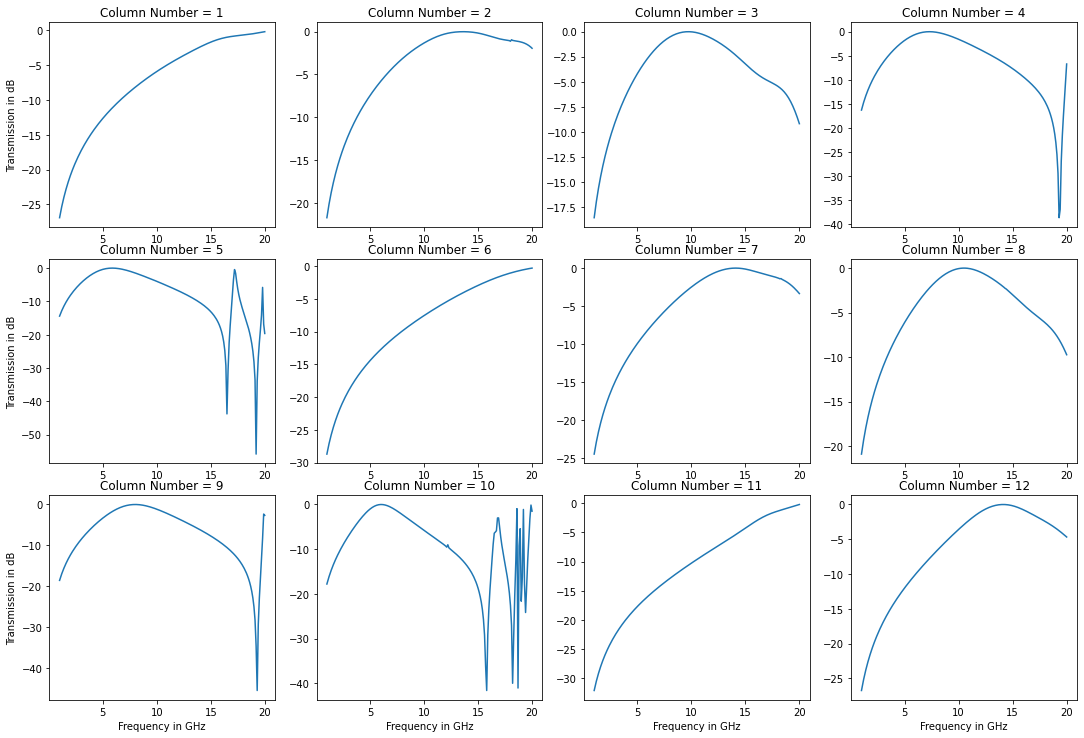

In [7]:
rows = 3
columns = 4
fig, window =  plt.subplots(rows, columns, figsize=(15,10))
fig.tight_layout()
for x in range(0,rows):
    for y in range(0, columns):
        index=1+x*columns+y
        window[x][y].title.set_text("Column Number = %d" % index)
        window[x][y].plot(data.iloc[:, 0], data.iloc[:, index])
plt.setp(window[-1, :], xlabel='Frequency in GHz');
plt.setp(window[:, 0], ylabel='Transmission in dB');

In [8]:
data

,Freq [GHz],"dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='2mm' g2='0mm' s1='1mm' s2='0.5mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='2mm' g2='0mm' s1='2mm' s2='0.5mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='2mm' g2='0mm' s1='3mm' s2='0.5mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='2mm' g2='0mm' s1='4mm' s2='0.5mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='2mm' g2='0mm' s1='5mm' s2='0.5mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='2mm' g2='0mm' s1='1mm' s2='1mm'",...,"dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='25mm' g2='0.5mm' s1='3mm' s2='1.25mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='25mm' g2='0.5mm' s1='3mm' s2='1.25mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='26mm' g2='0.5mm' s1='3mm' s2='1.25mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='27mm' g2='0.5mm' s1='3mm' s2='1.25mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='28mm' g2='0.5mm' s1='3mm' s2='1.25mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='29mm' g2='0.5mm' s1='3mm' s2='1.25mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='30mm' g2='0.5mm' s1='3mm' s2='1.25mm'"
0,1.0,-26.899047,-21.738253,-18.556836,-16.289351,-14.415687,-28.692293,...,-7.265652,-5.645212,-5.204043,-4.464106,-4.266679,-3.766259,-3.434368
1,1.1,-26.068833,-20.907403,-17.723808,-15.450868,-13.571228,-27.861928,...,-6.485358,-4.606957,-3.937370,-3.403295,-3.211120,-3.072333,-2.791153
2,1.2,-25.310477,-20.148358,-16.962408,-14.683555,-12.797495,-27.103407,...,-5.689933,-3.728026,-3.057601,-2.671631,-2.502974,-2.472662,-2.259897
3,1.3,-24.612427,-19.449567,-16.261093,-13.975885,-12.083003,-26.405176,...,-4.918349,-3.001734,-2.427417,-2.143363,-2.005741,-1.967932,-1.825790
4,1.4,-23.965701,-18.802051,-15.610893,-13.318908,-11.418845,-25.758255,...,-4.194210,-2.415776,-1.963066,-1.748497,-1.641100,-1.553973,-1.475002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,19.6,-0.321875,-1.548532,-7.952840,-21.568599,-18.472182,-0.438480,...,-0.066864,-0.431685,-0.195567,-1.824989,-0.232562,-0.685281,-0.110212
187,19.7,-0.293934,-1.631440,-8.234867,-17.505902,-14.123273,-0.407896,...,0.608630,-0.096940,-0.244043,-0.399914,-0.386374,-0.996297,-0.192498
188,19.8,-0.266269,-1.725217,-8.533635,-13.911005,-5.799198,-0.378492,...,-2.031433,-0.006268,-0.327730,-3.521001,-0.055126,-0.861759,-0.032996
189,19.9,-0.239161,-1.830872,-8.848792,-10.397368,-16.825132,-0.350309,...,-0.139061,-1.362638,-0.489126,-0.148383,-7.943026,0.157250,-0.160805


In [9]:
trans_cutoff = -0.45
output_data = np.empty((0,2),float)
index_range = np.empty((0,2), int)
indices = []
input_data = np.empty((0,4), float)
ignore_subsequent_cutoffs = True
for column in range(1, data.shape[1]):
  cutoff_index_curr = []
  first_cutoff_found = False
  for index in range(1, data.shape[0]):
    prev = data.iloc[index-1,column]
    curr = data.iloc[index,column]
    if prev < trans_cutoff and curr >= trans_cutoff \
    and not first_cutoff_found:
      cutoff_index_curr.append(index)
      first_cutoff_found = True
    if prev >= trans_cutoff and curr < trans_cutoff \
    and first_cutoff_found:
      cutoff_index_curr.append(index-1)
      first_cutoff_found = False
  if len(cutoff_index_curr) <= 1:
    continue
  elif len(cutoff_index_curr) % 2 != 0:
    cutoff_index_curr = cutoff_index_curr[0:-1]
  #print(cutoff_index_curr)
  cutoff_index_curr = np.array(cutoff_index_curr)
  cutoff_index_curr = cutoff_index_curr.reshape(-1, 2)
  if ignore_subsequent_cutoffs:
    cutoff_index_curr = cutoff_index_curr[0:1]
  for cutoff in cutoff_index_curr:
      indices.append(column)
      input_data = np.concatenate((input_data, X[column-1:column]))
      op_curr = np.array([data.iloc[cutoff, 0].to_numpy()])
      output_data = np.concatenate((output_data, op_curr))
  index_range= np.concatenate((index_range, cutoff_index_curr))
# print(output_data)
# print(index_range)
# print(input_data)
# print(indices)
print('''Total data points = %d
Useful data points = %d
Loss in data points = %d'''
%(data_points_initially, len(indices),
data_points_initially-len(indices)))

Total data points = 617
Useful data points = 501
Loss in data points = 116


In [10]:
use_old_method_of_data_cleaning = False
if use_old_method_of_data_cleaning:
  output_data = np.empty((0,2),float)
  index_range = np.empty((0,2), int)
  indices = []
  input_data = np.empty((0,4), float)
  r = -0.45
  r1 = -0.30
  r2 = -0.30
  rmin = -0.10
  for index in range(1, data.shape[1]):
      temp = []
      ix = []
      freq = []
      found = False
      for i, val in enumerate(data.iloc[:, index]):
          if r <= val:
              found = True
              temp.append(val)
              ix.append(i)
              freq.append(data.iloc[i, 0])
              continue
          if found:
              break
      if len(temp) >= 2 and temp[0] < r1 and temp[-1] < r2 and max(temp) > rmin:
          freq = np.array([[freq[0], freq[-1]]])
          ix = np.array(([[ix[0], ix[-1]]]))
          indices.append(index)
          index_range = np.concatenate((index_range, ix))
          output_data = np.concatenate((output_data, freq))
          input_data = np.concatenate((input_data, X[index-1:index]))
  # print(output_data)
  # print(index_range)
  # print(input_data)
  # print(indices)
  print('''Total data points = %d
  Useful data points = %d
  Loss in data points = %d'''
  %(data.shape[1]-1, len(indices),
  data.shape[1]-1-len(indices)))

In [11]:
dic = {}
for op in output_data:
  if dic.get(str(op), -1) == -1:
    dic[str(op)] = 1
  else:
    dic[str(op)] = dic[str(op)] + 1
freq_dic = {}
for key, value in dic.items():
  if freq_dic.get(value, -1) == -1:
    freq_dic[value] = 1
  else:
    freq_dic[value] = freq_dic[value] + 1
for key, value in freq_dic.items():
  print("output pairs repeating %d times = %d" % (key, value))

output pairs repeating 1 times = 327
output pairs repeating 2 times = 54
output pairs repeating 3 times = 15
output pairs repeating 4 times = 4
output pairs repeating 5 times = 1


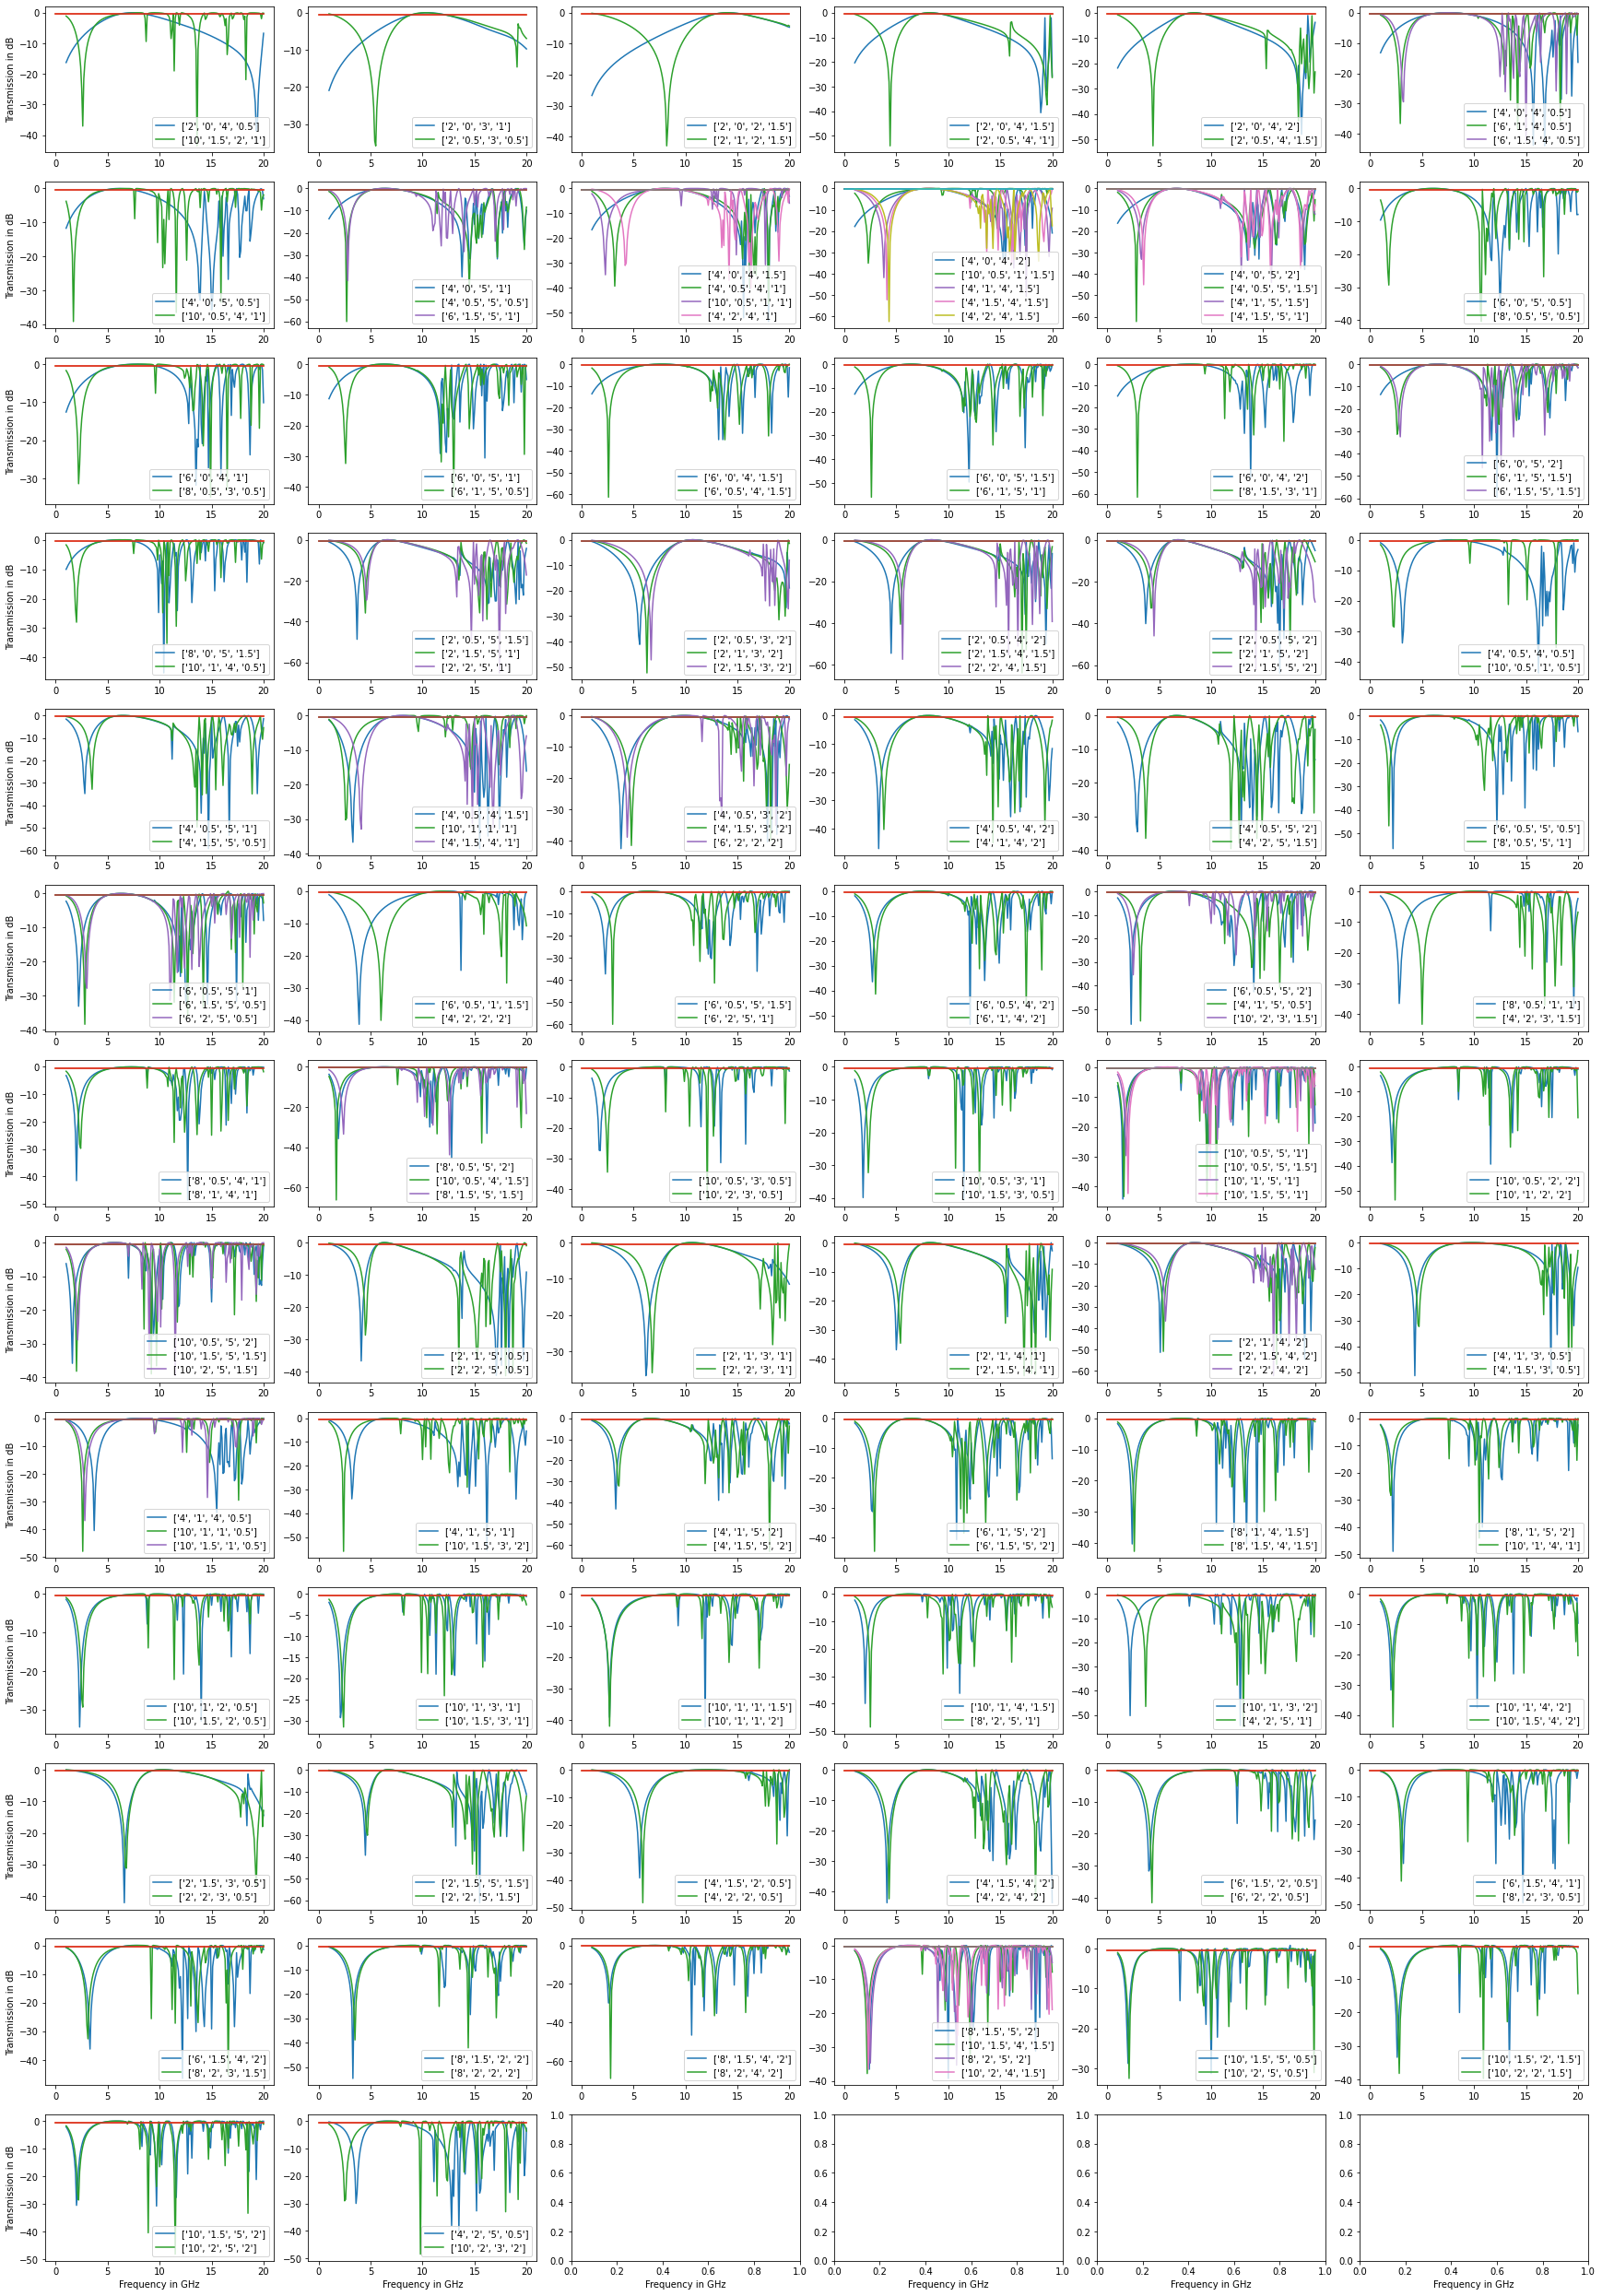

In [12]:
dic = {}
for index in range(0, output_data.shape[0]):
  if dic.get(str(output_data[index]), -1) == -1:
    dic[str(output_data[index])] = [list(input_data[index])]
  else:
    dic[str(output_data[index])].append(list(input_data[index]))
rep_dic={}
for key, elements in dic.items():
    if len(elements) > 1:
      rep_dic[key] = []
      for element in elements:
        l = []
        for val in element:
          if int(val) == val:
            l.append(str(int(val)))
          else:
            l.append(str(val))
        rep_dic [key].append(l)
final_dic = {}
for key, elements in rep_dic.items():
  final_dic[key] = []
  for element in elements:
    final_dic[key].append("dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='%smm' g2='%smm' s1='%smm' s2='%smm'"%(tuple(element)))
Plot = True
if Plot:
  rows = 13
  columns = 6
  fig, window =  plt.subplots(rows, columns, figsize=(30,45))
  plt.subplots_adjust(wspace=0.15, hspace=0.20)
  number = 0
  for key, elements in final_dic.items():
    col = number % columns
    row = number // columns
    number = number + 1
    for index, element in enumerate(elements):
      window[row][col].plot(data.iloc[:,0], data[element], label=str(rep_dic[key][index]))
      window[row][col].plot([0,20], [-0.45, -0.45])
    window[row][col].legend(loc ="lower right") 
    # window[row][col].title.set_text(str(rep_dic[key][0:2]))
  plt.setp(window[-1, :], xlabel='Frequency in GHz')
  plt.setp(window[:, 0], ylabel='Transmission in dB')
# for key, elements in rep_dic.items():
#     print(elements)

Text(0, 0.5, 'Transmission in dB')

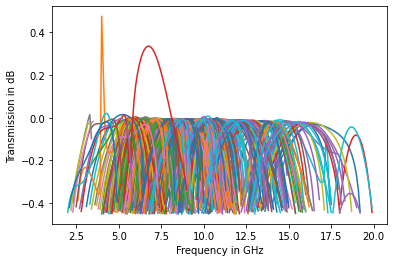

In [13]:
begin = 0
stop = np.inf
for i, index in enumerate(indices):
  if i>=begin and i<=stop:
    start = index_range[i][0]
    end = index_range[i][1]
    plt.plot(data.iloc[start:end+1, 0], data.iloc[start:end+1, index])
plt.xlabel('Frequency in GHz', fontsize=10)
plt.ylabel('Transmission in dB', fontsize=10)

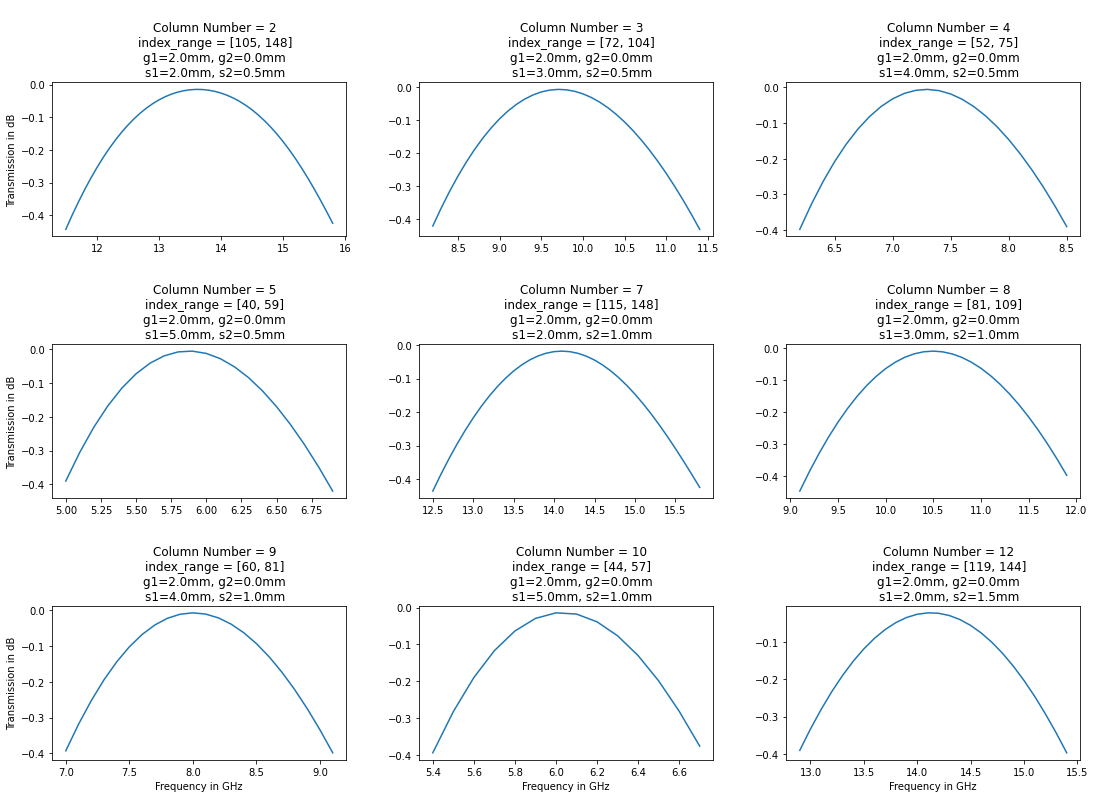

In [14]:
rows = 3
columns = 3
fig, window =  plt.subplots(rows, columns, figsize=(15,10))
fig.tight_layout()
for x in range(0,rows):
    for y in range(0, columns):
        position = x*columns+y
        column_index = indices[position]
        start = index_range[position][0]
        end = index_range[position][1]
        params=input_data[position]
        window[x][y].plot(data.iloc[start:end+1, 0], data.iloc[start:end+1, column_index])
        window[x][y].title.set_text('''
        Column Number = %d
        index_range = [%d, %d]
        g1=%.1fmm, g2=%.1fmm
        s1=%.1fmm, s2=%.1fmm''' 
        % (column_index, start, end, *params))
plt.subplots_adjust(wspace=0.25, hspace=0.7)
plt.setp(window[-1, :], xlabel='Frequency in GHz');
plt.setp(window[:, 0], ylabel='Transmission in dB');

In [15]:
Normalize=True
normalized_output = np.copy(output_data)
if Normalize:
  mean=[]
  sigma=[]
  for column in range(0,2):
    m = np.mean(output_data[:,column])
    s = np.max(output_data[:,column]) - np.min(output_data[:,column])
    mean.append(m)
    sigma.append(s)
    normalized_output[:,column]=(output_data[:,column]-m)/s
normalized_output[0:10,:]

array([[ 0.24215522,  0.33543756],
       [ 0.05029476,  0.07037732],
       [-0.06598431, -0.10432148],
       [-0.13575175, -0.20070702],
       [ 0.30029476,  0.33543756],
       [ 0.10262034,  0.1004978 ],
       [-0.01947268, -0.0681769 ],
       [-0.11249594, -0.21275521],
       [ 0.32355057,  0.31134117],
       [ 0.13169011,  0.1004978 ]])

In [16]:
Normalize_input=True
normalized_input = np.copy(input_data)
if Normalize_input:
  input_mean=[]
  input_sigma=[]
  for column in range(0,4):
      m = np.mean(input_data[:,column])
      s = np.max(input_data[:,column]) - np.min(input_data[:,column])
      if s == 0:
        s=1e-9
      input_mean.append(m)
      input_sigma.append(s)
      normalized_input[:,column]=(input_data[:,column]-m)/s
normalized_input

array([[-0.15562209, -0.49750499, -0.27195609, -0.50399202],
       [-0.15562209, -0.49750499, -0.02195609, -0.50399202],
       [-0.15562209, -0.49750499,  0.22804391, -0.50399202],
       ...,
       [ 0.71104458, -0.24750499, -0.02195609, -0.00399202],
       [ 0.74437791, -0.24750499, -0.02195609, -0.00399202],
       [ 0.77771124, -0.24750499, -0.02195609, -0.00399202]])

In [17]:

cleaned_data = np.concatenate((input_data, output_data), axis=1)
cleaned_data = pd.DataFrame(cleaned_data, columns=['g1 (mm)', 'g2 (mm)',
                                                   's1 (mm)', 's2 (mm)', 
                                                   'freq1 (GHz)', 'freq2 (GHz)'])
cleaned_data

,g1 (mm),g2 (mm),s1 (mm),s2 (mm),freq1 (GHz),freq2 (GHz)
0,2.0,0.0,2.0,0.50,11.5,15.8
1,2.0,0.0,3.0,0.50,8.2,11.4
2,2.0,0.0,4.0,0.50,6.2,8.5
3,2.0,0.0,5.0,0.50,5.0,6.9
4,2.0,0.0,2.0,1.00,12.5,15.8
...,...,...,...,...,...,...
496,26.0,0.5,3.0,1.25,2.3,3.5
497,27.0,0.5,3.0,1.25,2.3,3.4
498,28.0,0.5,3.0,1.25,2.2,3.3
499,29.0,0.5,3.0,1.25,2.0,4.9


In [18]:
for index in range(0,4):
  print(cleaned_data[cleaned_data.columns[index]].value_counts())

6.0     100
8.0     100
10.0    100
4.0      98
2.0      82
       ... 
24.0      1
26.0      1
27.0      1
28.0      1
19.0      1
Name: g1 (mm), Length: 22, dtype: int64
0.5    113
2.0    100
1.0     98
1.5     96
0.0     94
Name: g2 (mm), dtype: int64
3.0    117
5.0    103
4.0    100
2.0    100
1.0     81
Name: s1 (mm), dtype: int64
2.00    124
1.50    120
1.00    120
0.50    120
1.25     17
Name: s2 (mm), dtype: int64


In [19]:
def data(inp, op):
  return train_test_split(inp, op, test_size=0.2,
                          random_state=42,
                          shuffle=True)
def learn(epochs, seed=0):
  tf.random.set_seed(seed)
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(8,input_shape=(4,),activation='relu'))
  model.add(tf.keras.layers.Dense(32,activation='relu'))
  model.add(tf.keras.layers.Dense(2,activation='tanh'))
  model.compile(loss=tf.keras.losses.LogCosh(), optimizer='adam')
  history=model.fit(X_train, y_train, validation_split=0.25, epochs=epochs,
                    verbose=0, shuffle=True)
  return model, history

In [20]:
def input(inp, mean, sigma, Normalize):
  if Normalize:
    op=np.copy(inp)
    for column in range(0,4):
      op[:,column] = (inp[:,column]-mean[column])/(sigma[column])
    return op
  return inp
    
def output(prediction, mean, sigma, Normalize):
  if Normalize:
    op=np.copy(prediction[:])
    for column in range(0,2):
          op[:,column] = (prediction[:,column]*sigma[column])+mean[column]
    return op
  return prediction

In [21]:
#Good Seeds: 0, 5, 983, 732
acceptable_loss = 0.30
epochs = 2000
max_count = 9
initial_seed = 732
from sklearn.metrics import mean_absolute_error as mae
X_train, X_test, y_train, y_test = data(normalized_input, normalized_output)
model, history = learn(epochs, initial_seed)
prediction = output(model.predict(X_test), mean, sigma, Normalize)
y = output(y_test, mean, sigma, Normalize)
test_loss = mae(prediction, y)
min_loss_states=[]
while test_loss >= acceptable_loss and max_count>0:
  print("Test Loss very high, trying again. [test loss = %f]" % test_loss)
  X_train, X_test, y_train, y_test = data(normalized_input, normalized_output)
  ran_val = random.randint(1,1000)
  model, history = learn(epochs, ran_val)
  prediction = output(model.predict(X_test), mean, sigma, Normalize)
  y = output(y_test, mean, sigma, Normalize)
  test_loss = mae(prediction, y)
  min_loss_states.append([ran_val, test_loss])
  max_count = max_count - 1
print("test loss c1= %f, precision= %0.1f" % (mae(prediction[:,0], y[:,0]), 0.1))
print("test loss c2= %f, precision= %0.1f" % (mae(prediction[:,1], y[:,1]), 0.1))
print("test loss avg= %f" % test_loss)
min_loss_states.sort(key=lambda state: state[1])
print(min_loss_states)


test loss c1= 0.142232, precision= 0.1
test loss c2= 0.253045, precision= 0.1
test loss avg= 0.197639
[]


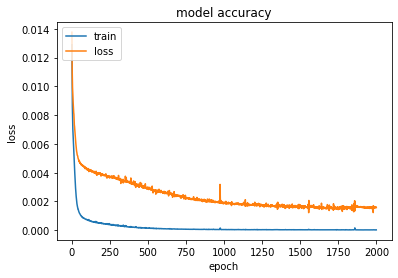

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'loss'], loc='upper left')
plt.show()

In [23]:
inp=input_data[30:40]
normal_input = input(inp, input_mean, input_sigma, Normalize_input)
normal_output = model.predict(normal_input)
result = output(normal_output, mean, sigma, Normalize)
result = result.round(1)
result = np.where(result<=0, 0, result)
print(result)
print(output_data[30:40])

[[10.5 14.1]
 [ 8.5 11.3]
 [ 7.   9.4]
 [ 5.9  7.5]
 [11.1 18.1]
 [ 8.2 14.7]
 [ 6.6 11.8]
 [ 5.4  9.4]
 [ 4.4  7.9]
 [10.9 16.9]]
[[10.9 14.3]
 [ 8.7 11.4]
 [ 7.   9.3]
 [ 5.8  7.7]
 [10.  18.2]
 [ 8.1 14.9]
 [ 6.6 11.9]
 [ 5.4  9.5]
 [ 4.5  7.7]
 [10.8 17.4]]


In [24]:
g1_range = np.arange(0.0, 12.1, 0.20)
g2_range = np.arange(0.0, 3.1, 0.10)
s1_range = np.arange(0.0, 7.1, 0.10)
s2_range = np.arange(0.0, 3.1, 0.10)
combs = []
for x in g1_range:
  for y in g2_range:
    for z in s1_range:
      for w in s2_range:
        arr = [x, y, z, w]
        combs.append(arr)
combs=np.array(combs)
print("total_points = %d" % combs.shape[0])

total_points = 4162091


In [25]:
inp = input(combs, input_mean, input_sigma, Normalize_input)
normal_output = model.predict(inp)
frequencies = output(normal_output, mean, sigma, Normalize)
frequencies = frequencies.round(3)
frequencies = np.where(frequencies<=0, 0, frequencies)
print(inp.shape)
print(frequencies.shape)

(4162091, 4)
(4162091, 2)


In [26]:
def find_best_match(frequencies, sizes, input):
  min_error = 100
  index = -1
  for ind, frequency in enumerate(frequencies):
    error = (abs(frequency[0]-input[0])+abs(frequency[1]-input[1]))/2
    if error < min_error:
      min_error = error
      index = ind
  e1 = abs(frequencies[index][0]-input[0])
  e2 = abs(frequencies[index][1]-input[1])
  return sizes[index], min_error, e1, e2

In [27]:
inps = np.array([[2,4],[3,5],[6,8],[8,10],[10,12],[12,14],[14,16],[16,18],[8,12],[6,14],[8,18]], dtype=np.float)
for input in inps:
  op1 = find_best_match(frequencies, combs,  input)
  op2 = find_best_match(output_data, input_data,  input)
  if op2[1] < op1[1] or op2[1] < test_loss:
    op1 = op2
  print(op1[0], 'eea = %0.2f, ee1 = %0.2f ee2 = %0.2f' %op1[1:])

[1.8 0.2 7.  0. ] eea = 0.21, ee1 = 0.10 ee2 = 0.31
[11.4  2.1  6.6  1.6] eea = 0.00, ee1 = 0.00 ee2 = 0.00
[10.   0.5  3.   2. ] eea = 0.15, ee1 = 0.20 ee2 = 0.10
[2.8 2.2 3.6 1.3] eea = 0.00, ee1 = 0.00 ee2 = 0.00
[2.  1.5 3.  1.5] eea = 0.10, ee1 = 0.20 ee2 = 0.00
[3.8 0.8 1.7 2.8] eea = 0.00, ee1 = 0.00 ee2 = 0.01
[5.2 0.3 0.4 2.8] eea = 0.00, ee1 = 0.00 ee2 = 0.00
[0.8 1.8 1.6 0.6] eea = 0.00, ee1 = 0.00 ee2 = 0.00
[4.  0.5 3.  0.5] eea = 0.15, ee1 = 0.10 ee2 = 0.20
[11.8  0.   0.1  0. ] eea = 0.26, ee1 = 0.50 ee2 = 0.03
[10.6  0.   0.   0. ] eea = 1.06, ee1 = 0.22 ee2 = 1.90


In [28]:
f_range = np.arange(1.0, 20.1, 0.1)
freq_combs = []
size = f_range.shape[0]
for x in range(0,size):
  for y in range(x+2, size):
      arr = [f_range[x],f_range[y]]
      freq_combs.append(arr)
freq_combs = np.array(freq_combs)
print("frequency combinations = %d" % freq_combs.shape[0])
count = 0
for input in freq_combs:
  op=find_best_match(output_data, input_data,  input)
  if op[1] < test_loss:
    count = count + 1
print("combinations for which ML model is not needed = %d" % count)

frequency combinations = 17955
combinations for which ML model is not needed = 3314


In [ ]:
 model.save('good.h5')
files.download('good.h5')